In [1]:
!nvidia-smi

Wed May 18 11:16:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Problem params
numClasses = 1000
realClassNumber = 5
if realClassNumber > 2:
  binaryClassification = False
else:
  binaryClassification = True

imageSizePx = 672#224
window_Size = int(7*(imageSizePx/224))


import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
  batchSize = 2#64 #224:64, 448:8, 672:2
else:
  batchSize = 32

#best for each model
#DR test

pretrainedPath = "/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224/MineUnsupervisedPretrainMOBY672/ckpt_epoch_10.pth"

#Top-1 models
#IMGNET SUPER 224 '/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224/ImageNetSupervisedPretrained224/ckpt_epoch_45.pth'
#random 224 "/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224/RandomInit224/ckpt_epoch_49.pth"
#ImageNet MOBY "/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224/ImageNetUnsupervisedPretrainMOBY224/ckpt_epoch_49.pth"
#MineMOBY224 "/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224/MineUnsupervisedPretrainMOBY224/ckpt_epoch_130.pth"
#MineMOBY448 "/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224/MineUnsupervisedPretrainMOBY448/ckpt_epoch_18.pth"
#672 "/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224/MineUnsupervisedPretrainMOBY672/ckpt_epoch_10.pth"

#Download dummy dataset and load csv
Change data format to class folder stucture train & val

In [3]:
#Upload kaggle api key to /content/

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir competitionKaggle
! pip install --upgrade --force-reinstall --no-deps kaggle

#https://www.kaggle.com/benjaminwarner/resized-2015-2019-blindness-detection-images
!kaggle datasets download -p /content/competitionKaggle/ -d benjaminwarner/resized-2015-2019-blindness-detection-images

!unzip /content/competitionKaggle/resized-2015-2019-blindness-detection-images.zip -d /content/competitionKaggle/
!rm /content/competitionKaggle/resized-2015-2019-blindness-detection-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/competitionKaggle/resized train 15/8514_left.jpg  
  inflating: /content/competitionKaggle/resized train 15/8514_right.jpg  
  inflating: /content/competitionKaggle/resized train 15/8515_left.jpg  
  inflating: /content/competitionKaggle/resized train 15/8515_right.jpg  
  inflating: /content/competitionKaggle/resized train 15/8517_left.jpg  
  inflating: /content/competitionKaggle/resized train 15/8517_right.jpg  
  inflating: /content/competitionKaggle/resized train 15/8519_left.jpg  
  inflating: /content/competitionKaggle/resized train 15/8519_right.jpg  
  inflating: /content/competitionKaggle/resized train 15/851_left.jpg  
  inflating: /content/competitionKaggle/resized train 15/851_right.jpg  
  inflating: /content/competitionKaggle/resized train 15/8522_left.jpg  
  inflating: /content/competitionKaggle/resized train 15/8522_right.jpg  
  inflating: /content/competitionKaggle/resized train 15/8526_left.jp

In [4]:
import pandas as pd

train = pd.read_csv("/content/competitionKaggle/labels/trainLabels15.csv")#"/content/competitionKaggle/trainLabels.csv")#"../input/com3025-2022-image-classification-challenge/train.csv"
train = train.astype('string')

test = pd.read_csv("/content/competitionKaggle/labels/testLabels15.csv")#"/content/competitionKaggle/trainLabels.csv")#"../input/com3025-2022-image-classification-challenge/train.csv"
test = test.astype('string')

train2 = pd.read_csv("/content/competitionKaggle/labels/trainLabels19.csv")#"/content/competitionKaggle/trainLabels.csv")#"../input/com3025-2022-image-classification-challenge/train.csv"
train2 = train2.astype('string')


def append_ext(fn):#add file extention to filenames
    return fn+".jpg"#".jpeg"#check converted file extention

train["image"]=train["image"].apply(append_ext)

test["image"]=test["image"].apply(append_ext)

train2["id_code"]=train2["id_code"].apply(append_ext)

#SAMPLE SMALLER FOR QUICK RUNS --------------------------------------------------------------------------------------------------------------------------------------------
#and making demo dataset
# train = train.sample(1000)
# test = test.sample(1000)
# train2 = train2.sample(1000)

In [5]:
!mkdir /content/competitionKaggle/train
!mkdir /content/competitionKaggle/val

In [6]:
#very quick
import os
import shutil

def createFolderTreeFromDataframe(df, folder, source, ycolumn, imageCol):
  for index, row in df.iterrows():#for every row
    image_class = row[ycolumn]#load the class
    if not os.path.exists(f'/content/competitionKaggle/{folder}/{image_class}'):#create class folder if it doesnt exist
      os.makedirs(f'/content/competitionKaggle/{folder}/{image_class}')
    image_name = row[imageCol]#load the filename
    shutil.move(f"/content/competitionKaggle/{source}/{image_name}", f"/content/competitionKaggle/{folder}/{image_class}/")#move that file to the new dest

createFolderTreeFromDataframe(train, "train", "resized train 15",'level', 'image')
createFolderTreeFromDataframe(test, "train", "resized test 15",'level', 'image')#put test in train as well
createFolderTreeFromDataframe(train2, "train", "resized train 19", 'diagnosis', 'id_code')#put test in train as well
#92364 total images

# createFolderTreeFromDataframe(test, "val", "resized test 15")

In [7]:
#----------------------put 20% of images in val
import os
import random
random.seed(0)

for i in range(5):
  files = os.listdir(f"/content/competitionKaggle/train/{i}")
  random.shuffle(files)
  files = files[:int(len(files)*0.2)]
  for fileName in files:
    if not os.path.exists(f'/content/competitionKaggle/val/{i}'):#create class folder if it doesnt exist
      os.makedirs(f'/content/competitionKaggle/val/{i}')
    shutil.move(f"/content/competitionKaggle/train/{i}/{fileName}", f"/content/competitionKaggle/val/{i}/")#move that file to the new dest

#Load data using dataloader

In [11]:
import torchvision
import torch

In [12]:
#Image norm transform
import torchvision.transforms as transforms


IMAGENET_DEFAULT_MEAN = [0.485, 0.456, 0.406]
IMAGENET_DEFAULT_STD = [0.229, 0.224, 0.225]

NORMtransform = transforms.Compose([
    transforms.Resize((imageSizePx, imageSizePx)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
])


In [13]:
DR_VAL_DATA = torchvision.datasets.ImageFolder('/content/competitionKaggle/val/',  transform = NORMtransform,)
data_loader = torch.utils.data.DataLoader(DR_VAL_DATA,
                                          batch_size=batchSize,
                                          shuffle=False,
                                          # transform = NORMtransform,
                                          # num_workers=args.nThreads
                                          )

#Model Code

In [14]:
!pip install timm

     |████████████████████████████████| 431 kB 14.8 MB/s 


In [15]:
import timm

In [16]:
# --------------------------------------------------------
# Swin Transformer
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ze Liu, Yutong Lin, Yixuan Wei
# --------------------------------------------------------

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
import numpy as np
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030
    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

def swin_t_patch4_224_diagnosis(image_size=224, pretrained=False, pretrainPath='', classNumber=2, windowSize=7, **kwargs):
    model = SwinTransformer(img_size=image_size, num_classes=classNumber, window_size=windowSize)
    if pretrained:
        checkpoint = torch.load(pretrainPath, map_location='cpu')
        state_dict = checkpoint['model']

        msg = model.load_state_dict(state_dict, strict=False)
        print(msg)

        print(f"=> loaded successfully {pretrainPath}")

        del checkpoint
        torch.cuda.empty_cache()
    return model

#Model Init

In [18]:
!pip install yacs

In [19]:
import yacs

#from checkpoint
pretrainedPath = pretrainedPath
model = swin_t_patch4_224_diagnosis(image_size=imageSizePx, pretrained=True, pretrainPath=pretrainedPath, classNumber=numClasses, windowSize=window_Size)#swin_t_patch4_224(pretrained=True)#timm.create_model('swin_base_patch4_window7_224', pretrained=True)
model.eval()

# if args.use_cuda:
model = model.to(device)#.cuda()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>
=> loaded successfully /content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224/MineUnsupervisedPretrainMOBY672/ckpt_epoch_10.pth


#Calc Metrics on val

##Setup Metrics

In [20]:
!pip install torchmetrics

     |████████████████████████████████| 409 kB 12.7 MB/s 


In [21]:
# import library
import torchmetrics

# from torchmetrics.functional import auc
from torchmetrics import AUROC
from torchmetrics import ROC
from torchmetrics import Specificity

from torchmetrics.classification import StatScores

from torchmetrics import Precision
from torchmetrics import Recall
from torchmetrics import Accuracy
from torchmetrics import F1Score
# from torchmetrics.functional import precision_recall
from torchmetrics import CohenKappa
from torchmetrics import PrecisionRecallCurve
from torchmetrics import ConfusionMatrix

#-------------------------------------------------------------Params
NumClasses = 5#1000#realClassNumber#1000#5



#-------------------------------------------------------------# initialize metrics
if binaryClassification: #determine threshold then other metrics
  roc_Metric = ROC(pos_label=1)
  # fpr, tpr, thresholds = roc(pred, target)
  pr_curve_Metric = PrecisionRecallCurve(pos_label=1)
  # precision, recall, thresholds = pr_curve(pred, target)
  #------------------------------------------------------
  auroc_Metric = AUROC(pos_label=1)
  # auroc(preds, target)
  stat_scores_Metric = StatScores(threshold=0.5, reduce='micro')
  # stat_scores(preds, target)
  precision_Metric = Precision(threshold=0.5, average='micro') #Default value of 0.5 corresponds to input being probabilities.
  # # precision(preds, target)
  recall_Metric = Recall(threshold=0.5, average='micro')
  # # recall(preds, target)
  # precision_recall(preds, target, average='macro', num_classes=NumClasses)#threshold=0.5
  f1_Metric = F1Score(threshold=0.5, average='micro')#threshold=0.5 
  # f1(preds, target)
  specificity_Metric = Specificity(threshold=0.5, average='micro')
  # specificity = Specificity(average='micro')
  # specificity(preds, target)
  accuracy_Metric = Accuracy(threshold=0.5, average='micro')#threshold=0.5
  # accuracy(preds, target)
  cohenkappa_Metric = CohenKappa(num_classes=NumClasses, threshold=0.5)#threshold=0.5
  # cohenkappa(preds, target)
  confmat = ConfusionMatrix(num_classes=NumClasses, threshold=0.5)
  # confmat(preds, target)

  BinaryMetricsThresh = [roc_Metric, pr_curve_Metric]
  BinaryMetrics = [auroc_Metric, stat_scores_Metric, precision_Metric, recall_Metric, f1_Metric, specificity_Metric, accuracy_Metric, cohenkappa_Metric, confmat]

  for metric in BinaryMetricsThresh:
    metric.to(device)
  for metric in BinaryMetrics:
    metric.to(device)
else:
  auroc_Metric = AUROC(num_classes=NumClasses)
  # stat_scores_Metric = StatScores(num_classes=NumClasses, reduce='macro')#reduce='micro'
  precision_Metric = Precision(num_classes=NumClasses, average='macro') #Default value of 0.5 corresponds to input being probabilities.
  recall_Metric = Recall(num_classes=NumClasses, average='macro')
  f1_Metric = F1Score(num_classes=NumClasses, average='macro')#threshold=0.5 
  accuracy_Metric = Accuracy(num_classes=NumClasses, average='macro')#threshold=0.5
  cohenkappa_Metric = CohenKappa(num_classes=NumClasses)#threshold=0.5
  confmat = ConfusionMatrix(num_classes=NumClasses)
  # confmat(preds, target)
  MultiClassMetrics = {
      "Area Under ROC Curve" : auroc_Metric,
      "Precision" : precision_Metric,
      "Recall" : recall_Metric,
      "F1 Score" : f1_Metric,
      "Accuracy" : accuracy_Metric,
      "Cohen kappa coefficient" : cohenkappa_Metric,
      "Confusion Matrix" : confmat,
  }

  # for metric in MultiClassMetrics:
  for key, metric in MultiClassMetrics.items():
    metric.to(device)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


#Binary Classification metrics

In [115]:
#Find best thresh - for binary only....
import time
import datetime
from tqdm import tqdm

start_time = time.time()
for idx, (samples_1, targets) in enumerate(tqdm(data_loader)):
  input_tensor_cuda=samples_1.cuda()
  output = model(input_tensor_cuda)

  preds = output.detach()
  target = targets.cuda()

  preds = preds[: , :realClassNumber]#remove extra classes ------------------------- :(

  fpr, tpr, thresholds = roc_Metric(preds, target)
  precision, recall, thresholds = pr_curve_Metric(preds, target)
  # print(f"Accuracy on batch {idx}: {acc}")

# metric on all batches
roc = roc_Metric.compute()
pr_curve = pr_curve_Metric.compute()
print(f"\nroc on all data: {roc}\n pr curve on all data: {pr_curve}")

# Reseting internal state such that metric ready for new data
roc_Metric.reset()
pr_curve_Metric.reset()

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('\nTesting time {}'.format(total_time_str))

  0%|          | 0/289 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
100%|██████████| 289/289 [06:24<00:00,  1.33s/it]


roc on all data: ([tensor([0.0000, 0.0000, 0.0000,  ..., 0.9996, 0.9998, 1.0000], device='cuda:0'), tensor([0.0000, 0.0000, 0.0000,  ..., 0.9999, 0.9999, 1.0000], device='cuda:0'), tensor([0.0000, 0.0000, 0.0000,  ..., 0.9999, 0.9999, 1.0000], device='cuda:0'), tensor([0.0000, 0.0000, 0.0000,  ..., 0.9999, 0.9999, 1.0000], device='cuda:0'), tensor([0.0000, 0.0000, 0.0000,  ..., 0.9999, 0.9999, 1.0000], device='cuda:0')], [tensor([0.0000e+00, 7.4466e-05, 1.4893e-04,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], device='cuda:0'), tensor([0.0000e+00, 7.6046e-04, 1.5209e-03,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], device='cuda:0'), tensor([0.0000e+00, 3.5336e-04, 7.0671e-04,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], device='cuda:0'), tensor([0.0000, 0.0022, 0.0044,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0'), tensor([0.0000, 0.0023, 0.0045,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0')], [tensor([8.3364, 7.3364, 7.3321,  ..., 2.5712, 2.5685, 2.5385], device=

In [116]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
# print(roc)
fpr, tpr, thresholdsroc = roc
# print(fpr, tpr, thresholdsroc,sep='\n')
# fpr = fpr.cpu()
fpr = [t.cpu().numpy() for t in fpr]
tpr = [t.cpu().numpy() for t in tpr]#tpr.cpu()
thresholdsroc = [t.cpu().numpy() for t in thresholdsroc]#thresholdsroc.cpu()
print(fpr, tpr, thresholdsroc,sep='\n')

print("\n")

# print(pr_curve)
precision, recall, thresholdsPRC = pr_curve
# print(precision, recall, thresholdsPRC, sep='\n')
precision = [t.cpu().numpy() for t in precision]#precision.cpu()
recall = [t.cpu().numpy() for t in recall]#recall.cpu()
thresholdsPRC = [t.cpu().numpy() for t in thresholdsPRC]#thresholdsPRC.cpu()
print(precision, recall, thresholdsPRC, sep='\n')

[array([ 0.000,  0.000,  0.000, ...,  1.000,  1.000,  1.000], dtype=float32), array([ 0.000,  0.000,  0.000, ...,  1.000,  1.000,  1.000], dtype=float32), array([ 0.000,  0.000,  0.000, ...,  1.000,  1.000,  1.000], dtype=float32), array([ 0.000,  0.000,  0.000, ...,  1.000,  1.000,  1.000], dtype=float32), array([ 0.000,  0.000,  0.000, ...,  1.000,  1.000,  1.000], dtype=float32)]
[array([ 0.000,  0.000,  0.000, ...,  1.000,  1.000,  1.000], dtype=float32), array([ 0.000,  0.001,  0.002, ...,  1.000,  1.000,  1.000], dtype=float32), array([ 0.000,  0.000,  0.001, ...,  1.000,  1.000,  1.000], dtype=float32), array([ 0.000,  0.002,  0.004, ...,  1.000,  1.000,  1.000], dtype=float32), array([ 0.000,  0.002,  0.005, ...,  1.000,  1.000,  1.000], dtype=float32)]
[array([ 8.336,  7.336,  7.332, ...,  2.571,  2.569,  2.538], dtype=float32), array([ 7.834,  6.834,  6.808, ...,  0.786,  0.720,  0.704], dtype=float32), array([ 8.453,  7.453,  7.159, ...,  1.489,  1.331,  1.242], dtype=float3

In [81]:
# !pip install ggplot
# !pip install tslib

In [118]:
fpr=fpr[0]
tpr=tpr[0]
# thresholdsroc=thresholdsroc[0]

(18388,) (18388,)


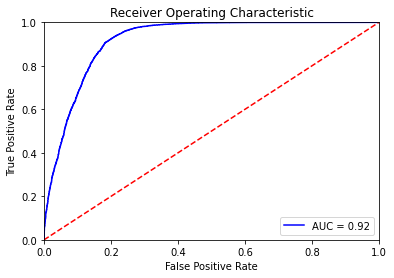

In [108]:
import sklearn.metrics as metrics
import pandas
# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
# fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
print(np.shape(fpr), np.shape(tpr))
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# # method II: ggplot
# from ggplot import *
# df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
# ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

[]

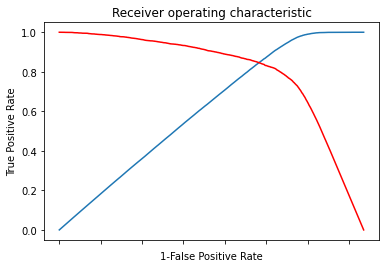

In [111]:
import pandas as pd
####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholdsroc, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [120]:
i = np.arange(len(tpr)) 
rocs = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(thresholdsroc, index=i)})
roc_t = rocs.iloc[(rocs.tf-0).abs().argsort()[:1]]
print(roc_t)

ValueError: ignored

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: ignored

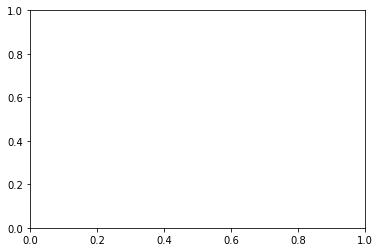

In [91]:
import matplotlib.pyplot as plt
# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k-')
# plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(0.9932))#roc_auc))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

# plt.figure(1)
# lw = 2
# plt.plot(fpr, tpr, color="darkorange", label="CNN (area = {:.3f})".format(0.9932))#roc_auc))
# plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc="lower right")
# plt.show()

#Multiclass metrics

In [22]:
#-------------------------------------------------------------Run batches
import time
import datetime
from tqdm import tqdm

import itertools#for testing limit size
# slicedDataloader = itertools.islice(data_loader, 1000)

# batch = next(iter(dataloader_train))

start_time = time.time()
for idx, (samples_1, targets) in enumerate(tqdm(data_loader)):
  input_tensor_cuda=samples_1.to(device)#.cuda()
  output = model(input_tensor_cuda)

  preds = output.detach()
  target = targets.to(device)
  preds = preds[: , :realClassNumber]#remove extra classes ------------------------- (also adjust classes given to metrics to only 5)

  # metric on current batch
  for key, metric in MultiClassMetrics.items():
    metric(preds, target)

# metric on all batches using custom accumulation
metricsValues = {key:metric.compute() for key, metric in MultiClassMetrics.items()}

print(f"\nMetrics on all data: ")
# for metricsResult in metricsList:
for key, metric in metricsValues.items():#Print results
  print(f"{key}: {metric}")

# Reseting internal state such that metric ready for new data
for key, metric in MultiClassMetrics.items():
  metric.reset()

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Testing time {}'.format(total_time_str))

  0%|          | 0/9236 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
100%|██████████| 9236/9236 [20:39<00:00,  7.45it/s]


Metrics on all data: 
Area Under ROC Curve: 0.8337730765342712
Precision: 0.5307272672653198
Recall: 0.43575143814086914
F1 Score: 0.461001992225647
Accuracy: 0.43575143814086914
Cohen kappa coefficient: 0.5151712894439697
Confusion Matrix: tensor([[13218,     0,   190,     1,    20],
        [ 1064,     0,   247,     0,     4],
        [ 1073,     0,  1671,    34,    52],
        [   30,     0,   306,    80,    40],
        [   67,     0,   148,    37,   189]], device='cuda:0')
Testing time 0:20:40


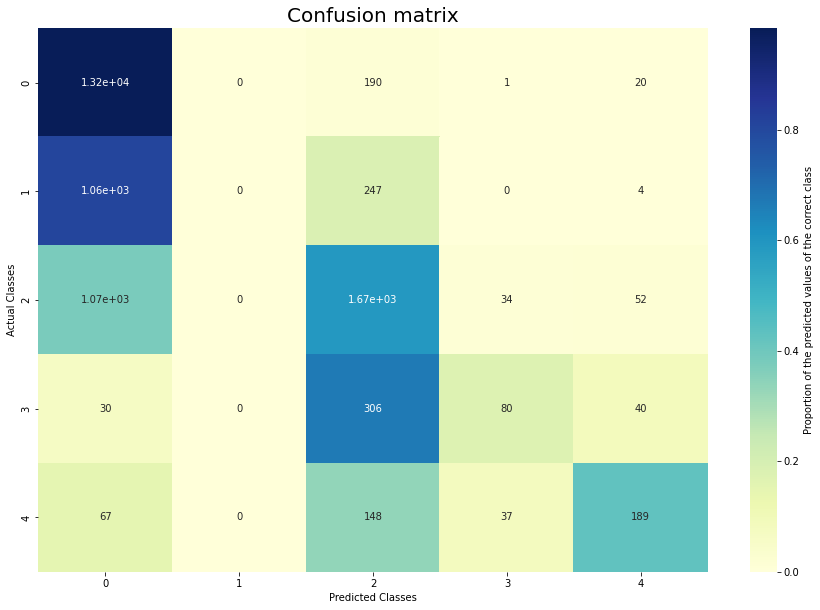

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
#Get the conv mat
conf_mat = metricsValues["Confusion Matrix"].to('cpu').numpy()


plt.figure(figsize = (15,10))
# Normalize it by row: for colouring
# RowNormConvMat = conf_mat / conf_mat.astype(np.float).sum(axis=1)
RowNormConvMat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
 
# And see the result
sns.heatmap(RowNormConvMat, annot= conf_mat, cmap='YlGnBu', fmt = ".3g", cbar_kws={'label': 'Proportion of the predicted values of the correct class'})
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.title("Confusion matrix", fontsize = 20)
plt.show()
# sns.heatmap(conf_mat, annot=True)